### Description: 
In this Notebook, I will load finetuned weight and necessary libraries. and perfom prediction....

In [1]:
pip install -q super-gradients

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda create -n ai_proj python=3.10

^C

Note: you may need to restart the kernel to use updated packages.


In [1]:

import torch
from super_gradients.training import models
yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")


ModuleNotFoundError: No module named 'super_gradients'

In [9]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [10]:
from torchinfo import summary

summary(model=yolo_nas_l, 
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

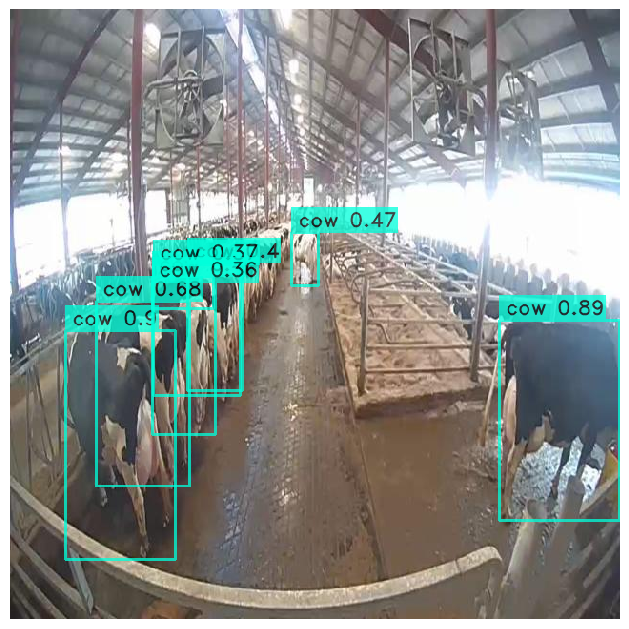

In [11]:
url = "/Users/mautushid/github/Yolo_Nas/cow_test.v1i.yolov5pytorch/test/images/img_1_jpg.rf.f874b8a814a980341ea520c40df12def.jpg"
yolo_nas_l.predict(url, conf=0.35).show()


In [12]:
def count_cows(predicted_image):
  predictions = predicted_image  # replace this with actual output of your model
  number_of_boxes = 0
  for prediction in predictions:
    number_of_boxes += prediction.prediction.bboxes_xyxy.shape[0]

  return number_of_boxes


In [13]:
predicted_image = yolo_nas_l.predict(url, conf=0.35)
print('Total Cow predicted:',count_cows(predicted_image))

Total Cow predicted: 8


In [15]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"


In [ ]:
### Finetuning Starts here

In [27]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run',
                  ckpt_root_dir=CHECKPOINT_DIR)


In [16]:
#!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="cF1Uo6xTLKOH21FeLvnt")
project = rf.workspace("vt-eyajq").project("cow_test-amlio")
dataset = project.version(1).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to cow_test-1 in yolov5pytorch:: 100%|██████████| 114/114 [00:00<00:00, 3015.32it/s]


In [17]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val


In [20]:
dataset_params = {
    'data_dir': '/Users/mautushid/github/Yolo_Nas/cow_test-1',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': ['cow']
}


In [21]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

clear_output()


Caching annotations: 100%|██████████| 6/6 [00:00<00:00, 958.19it/s]


In [24]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )


[2023-05-14 20:02:33] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [29]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 20,  # was 10
    "mixed_precision": False, # was True
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [30]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)


[2023-05-14 20:14:29] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yolonas_run/console_May14_20_14_29.txt


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[2023-05-14 20:15:00] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Dataset size:                 34         (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         2          (len(train_lo

Validation epoch 20: 100%|██████████| 1/1 [00:12<00:00, 12.78s/it]
[2023-05-14 20:54:50] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 2.0815
│   │   ├── Best until now = 2.0985 (↘ -0.0169)
│   │   └── Epoch N-1      = 2.1321 (↘ -0.0506)
│   ├── Ppyoloeloss/loss_cls = 0.9256
│   │   ├── Best until now = 0.9327 (↘ -0.0071)
│   │   └── Epoch N-1      = 0.9327 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_dfl = 1.2427
│   │   ├── Best until now = 1.2291 (↗ 0.0136)
│   │   └── Epoch N-1      = 1.2701 (↘ -0.0274)
│   └── Ppyoloeloss/loss_iou = 0.2138
│       ├── Best until now = 0.2192 (↘ -0.0054)
│       └── Epoch N-1      = 0.2258 (↘ -0.0119)
└── Validation
    ├── F1@0.50 = 0.057
    │   ├── Best until now = 0.0527 (↗ 0.0043)
    │   └── Epoch N-1      = 0.0518 (↗ 0.0051)
    ├── Map@0.50 = 0.3052
    │   ├── Best until now = 0.2646 (↗ 0.0406)
    │   └── Epoch N-1      = 0.2646 (↗ 0.0406)
    ├── Ppyoloeloss/loss = 107.5686
    │   ├── Best until now = 3.4133 (↗ 104.1553)
    │   └── Epoch N-1      = 76.5409 (↗ 31.0277)
    ├── Ppyoloeloss/loss_cls = 106.1929
    │   ├

In [56]:
## latest = "/Users/mautushid/github/Yolo_Nas/checkpoints/downloded_weights/ckpt_latest (1).pth"
## best = "/Users/mautushid/github/Yolo_Nas/checkpoints/downloded_weights/ckpt_best.pth"
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/Users/mautushid/github/Yolo_Nas/checkpoints/downloded_weights/ckpt_best.pth")


[2023-05-15 17:12:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Yolo_Nas/checkpoints/downloded_weights/ckpt_best.pth EMA checkpoint.


In [57]:
trainer.test(model=best_model,
             test_loader=test_data,
             test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                    top_k_predictions=300,
                                                    num_cls=len(
                                                        dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7)
                                                    ))


Test:   0%|          | 0/1 [00:00<?, ?it/s][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Test: 100%|██████████| 1/1 [00:17<00:00, 17.42s/it]

{'PPYoloELoss/loss_cls': 59.47539,
 'PPYoloELoss/loss_iou': 0.23421475,
 'PPYoloELoss/loss_dfl': 1.4033761,
 'PPYoloELoss/loss': 60.762615,
 'Precision@0.50': tensor(0.0321),
 'Recall@0.50': tensor(0.9048),
 'mAP@0.50': tensor(0.5287),
 'F1@0.50': tensor(0.0620)}

Test: 100%|██████████| 1/1 [00:22<00:00, 22.42s/it]


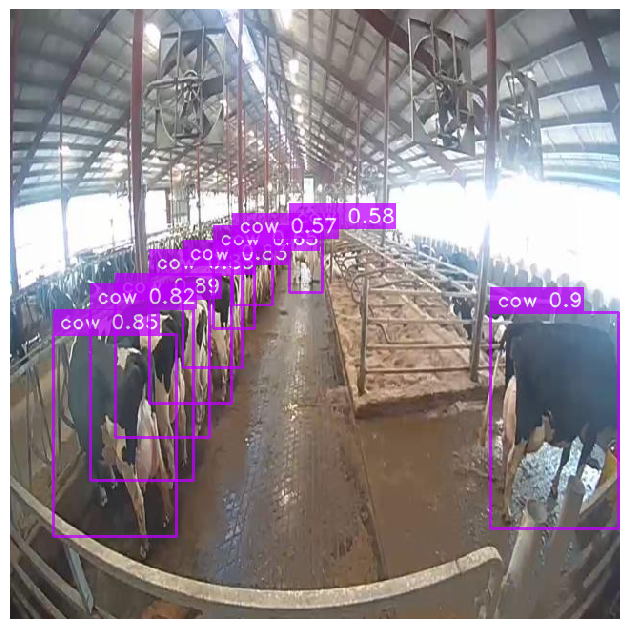

In [60]:
img_url = "/Users/mautushid/github/Yolo_Nas/cow_test.v1i.yolov5pytorch/test/images/img_1_jpg.rf.f874b8a814a980341ea520c40df12def.jpg"
#img_url = 'https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'
best_model.predict(img_url,conf = 0.55).show()